In [1]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
import zipfile
from torch.utils import data
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Jo

In [2]:
Dataset = "train"
Dataset1 = "test"
Dataset2 = "flamingo"

with zipfile.ZipFile("../input/tgs-salt-identification-challenge/"+Dataset+".zip","r") as z:
    z.extractall("./")
    
with zipfile.ZipFile("../input/tgs-salt-identification-challenge/"+Dataset1+".zip","r") as z:
    z.extractall("./")
    
with zipfile.ZipFile("../input/tgs-salt-identification-challenge/"+Dataset2+".zip","r") as z:
    z.extractall("./")

In [3]:
class TGSSaltDataset(data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
    
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))

        file_id = self.file_list[index]
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        return image, mask

In [4]:

train_mask = pd.read_csv('../input/tgs-salt-identification-challenge/train.csv')

depth = pd.read_csv('../input/tgs-salt-identification-challenge/depths.csv')

train_path = "train/"

file_list = list(train_mask['id'].values)

dataset = TGSSaltDataset(train_path, file_list)

In [5]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

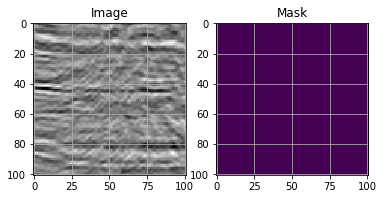

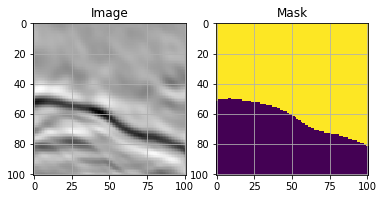

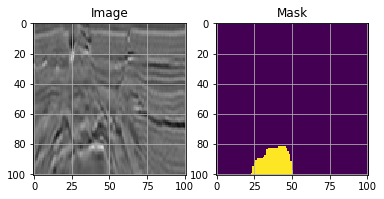

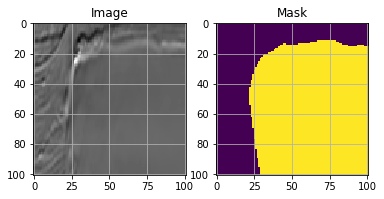

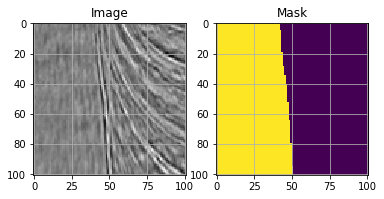

In [6]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

Text(0.5, 1.0, 'Depth distribution')

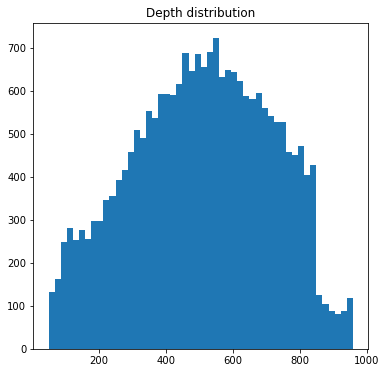

In [7]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

In [8]:
def rleToMask(rleString,height,width):
    rows,cols = height,width
    try:
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        
        for index,length in rlePairs:
        
            index -= 1
            img[index:index+length] = 255
        
        
        
        img = img.reshape(cols,rows)
        img = img.T
    
    
    except:
        img = np.zeros((cols,rows))
    
    return img

In [9]:
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        
        return counts[1]/10201.
    
    except: 
        return 0.0

In [10]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [11]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5, 1.0, 'Proportion of salt v. depth')

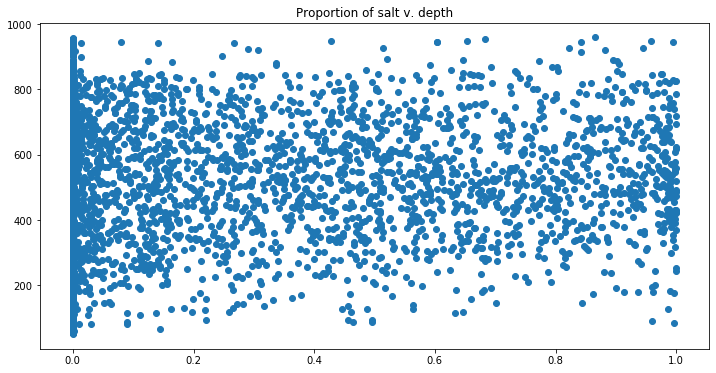

In [12]:
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')

In [13]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])

Correlation:  0.10361580365557439


In [14]:
im_width = 128
im_height = 128
border = 5
im_chan = 2
n_features = 1

In [15]:
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)

u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [16]:
model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
train_ids = next(os.walk(train_path+"images/"))[2]

X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
len(train_ids)

Getting and resizing train images and masks ... 


4000

In [18]:

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + 'images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())
    
    mask = img_to_array(load_img(path + 'masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:50<00:00, 79.09it/s]


In [19]:
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [20]:

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - ETA: 53:26 - loss: 0.70 - ETA: 27:15 - loss: 0.69 - ETA: 18:28 - loss: 0.69 - ETA: 14:03 - loss: 0.69 - ETA: 11:24 - loss: 0.69 - ETA: 9:39 - loss: 0.6933 - ETA: 8:23 - loss: 0.692 - ETA: 7:26 - loss: 0.691 - ETA: 6:42 - loss: 0.690 - ETA: 6:06 - loss: 0.689 - ETA: 5:37 - loss: 0.686 - ETA: 5:13 - loss: 0.681 - ETA: 4:52 - loss: 0.679 - ETA: 4:34 - loss: 0.671 - ETA: 4:19 - loss: 0.654 - ETA: 4:06 - loss: 0.667 - ETA: 3:54 - loss: 0.665 - ETA: 3:43 - loss: 0.660 - ETA: 3:33 - loss: 0.658 - ETA: 3:25 - loss: 0.652 - ETA: 3:17 - loss: 0.652 - ETA: 3:10 - loss: 0.648 - ETA: 3:03 - loss: 0.648 - ETA: 2:57 - loss: 0.649 - ETA: 2:52 - loss: 0.648 - ETA: 2:46 - loss: 0.649 - ETA: 2:42 - loss: 0.646 - ETA: 2:37 - loss: 0.645 - ETA: 2:33 - loss: 0.645 - ETA: 2:29 - loss: 0.643 - ETA: 2:25 - loss: 0.642 - ETA: 2:22 - loss: 0.638 - ETA: 2:18 - loss: 0.637 - ETA: 2:15 - loss: 0.635 - ETA: 2:12 - 

3400/3400 [==============================] - ETA: 1:05 - loss: 0.518 - ETA: 1:05 - loss: 0.553 - ETA: 1:05 - loss: 0.515 - ETA: 1:05 - loss: 0.494 - ETA: 1:07 - loss: 0.491 - ETA: 1:07 - loss: 0.484 - ETA: 1:06 - loss: 0.483 - ETA: 1:06 - loss: 0.483 - ETA: 1:05 - loss: 0.490 - ETA: 1:05 - loss: 0.487 - ETA: 1:04 - loss: 0.481 - ETA: 1:04 - loss: 0.491 - ETA: 1:03 - loss: 0.504 - ETA: 1:03 - loss: 0.502 - ETA: 1:03 - loss: 0.497 - ETA: 1:02 - loss: 0.491 - ETA: 1:02 - loss: 0.495 - ETA: 1:02 - loss: 0.496 - ETA: 1:01 - loss: 0.489 - ETA: 1:01 - loss: 0.487 - ETA: 1:01 - loss: 0.485 - ETA: 1:00 - loss: 0.485 - ETA: 1:00 - loss: 0.484 - ETA: 1:00 - loss: 0.483 - ETA: 59s - loss: 0.480 - ETA: 59s - loss: 0.48 - ETA: 59s - loss: 0.48 - ETA: 59s - loss: 0.48 - ETA: 58s - loss: 0.48 - ETA: 58s - loss: 0.48 - ETA: 58s - loss: 0.48 - ETA: 58s - loss: 0.48 - ETA: 58s - loss: 0.48 - ETA: 57s - loss: 0.48 - ETA: 57s - loss: 0.48 - ETA: 57s - loss: 0.48 - ETA: 56s - loss: 0.47 - ETA: 56s - loss: 0

3400/3400 [==============================] - ETA: 1:07 - loss: 0.617 - ETA: 1:07 - loss: 0.493 - ETA: 1:07 - loss: 0.476 - ETA: 1:07 - loss: 0.499 - ETA: 1:07 - loss: 0.489 - ETA: 1:07 - loss: 0.477 - ETA: 1:06 - loss: 0.458 - ETA: 1:06 - loss: 0.452 - ETA: 1:05 - loss: 0.438 - ETA: 1:05 - loss: 0.432 - ETA: 1:05 - loss: 0.435 - ETA: 1:04 - loss: 0.424 - ETA: 1:04 - loss: 0.427 - ETA: 1:04 - loss: 0.434 - ETA: 1:03 - loss: 0.437 - ETA: 1:03 - loss: 0.439 - ETA: 1:03 - loss: 0.436 - ETA: 1:03 - loss: 0.438 - ETA: 1:02 - loss: 0.437 - ETA: 1:02 - loss: 0.439 - ETA: 1:02 - loss: 0.433 - ETA: 1:01 - loss: 0.428 - ETA: 1:01 - loss: 0.427 - ETA: 1:01 - loss: 0.431 - ETA: 1:00 - loss: 0.424 - ETA: 1:00 - loss: 0.430 - ETA: 1:00 - loss: 0.435 - ETA: 59s - loss: 0.433 - ETA: 59s - loss: 0.43 - ETA: 59s - loss: 0.43 - ETA: 58s - loss: 0.43 - ETA: 58s - loss: 0.43 - ETA: 58s - loss: 0.43 - ETA: 57s - loss: 0.43 - ETA: 57s - loss: 0.43 - ETA: 57s - loss: 0.42 - ETA: 56s - loss: 0.42 - ETA: 56s - l

3400/3400 [==============================] - ETA: 1:08 - loss: 0.299 - ETA: 1:08 - loss: 0.277 - ETA: 1:08 - loss: 0.260 - ETA: 1:08 - loss: 0.264 - ETA: 1:08 - loss: 0.233 - ETA: 1:07 - loss: 0.297 - ETA: 1:07 - loss: 0.329 - ETA: 1:07 - loss: 0.342 - ETA: 1:06 - loss: 0.322 - ETA: 1:06 - loss: 0.317 - ETA: 1:06 - loss: 0.307 - ETA: 1:06 - loss: 0.306 - ETA: 1:05 - loss: 0.311 - ETA: 1:05 - loss: 0.303 - ETA: 1:05 - loss: 0.303 - ETA: 1:04 - loss: 0.299 - ETA: 1:04 - loss: 0.301 - ETA: 1:04 - loss: 0.300 - ETA: 1:03 - loss: 0.300 - ETA: 1:03 - loss: 0.298 - ETA: 1:03 - loss: 0.298 - ETA: 1:02 - loss: 0.307 - ETA: 1:02 - loss: 0.316 - ETA: 1:02 - loss: 0.306 - ETA: 1:01 - loss: 0.305 - ETA: 1:01 - loss: 0.303 - ETA: 1:01 - loss: 0.304 - ETA: 1:00 - loss: 0.308 - ETA: 1:00 - loss: 0.310 - ETA: 1:00 - loss: 0.313 - ETA: 59s - loss: 0.311 - ETA: 59s - loss: 0.31 - ETA: 59s - loss: 0.31 - ETA: 58s - loss: 0.31 - ETA: 58s - loss: 0.31 - ETA: 58s - loss: 0.31 - ETA: 57s - loss: 0.31 - ETA: 5

3400/3400 [==============================] - ETA: 1:09 - loss: 0.244 - ETA: 1:09 - loss: 0.322 - ETA: 1:09 - loss: 0.288 - ETA: 1:09 - loss: 0.299 - ETA: 1:09 - loss: 0.323 - ETA: 1:08 - loss: 0.297 - ETA: 1:08 - loss: 0.271 - ETA: 1:08 - loss: 0.281 - ETA: 1:07 - loss: 0.269 - ETA: 1:07 - loss: 0.266 - ETA: 1:07 - loss: 0.266 - ETA: 1:07 - loss: 0.266 - ETA: 1:06 - loss: 0.262 - ETA: 1:06 - loss: 0.254 - ETA: 1:06 - loss: 0.246 - ETA: 1:05 - loss: 0.243 - ETA: 1:05 - loss: 0.238 - ETA: 1:05 - loss: 0.255 - ETA: 1:04 - loss: 0.252 - ETA: 1:04 - loss: 0.247 - ETA: 1:04 - loss: 0.243 - ETA: 1:04 - loss: 0.242 - ETA: 1:03 - loss: 0.247 - ETA: 1:03 - loss: 0.254 - ETA: 1:03 - loss: 0.250 - ETA: 1:02 - loss: 0.248 - ETA: 1:02 - loss: 0.245 - ETA: 1:01 - loss: 0.244 - ETA: 1:01 - loss: 0.245 - ETA: 1:01 - loss: 0.245 - ETA: 1:00 - loss: 0.250 - ETA: 1:00 - loss: 0.252 - ETA: 1:00 - loss: 0.250 - ETA: 59s - loss: 0.251 - ETA: 59s - loss: 0.25 - ETA: 59s - loss: 0.25 - ETA: 58s - loss: 0.25 - 

3400/3400 [==============================] - ETA: 1:09 - loss: 0.195 - ETA: 1:10 - loss: 0.222 - ETA: 1:11 - loss: 0.201 - ETA: 1:11 - loss: 0.232 - ETA: 1:10 - loss: 0.241 - ETA: 1:10 - loss: 0.241 - ETA: 1:09 - loss: 0.239 - ETA: 1:09 - loss: 0.226 - ETA: 1:09 - loss: 0.236 - ETA: 1:08 - loss: 0.226 - ETA: 1:08 - loss: 0.226 - ETA: 1:07 - loss: 0.226 - ETA: 1:07 - loss: 0.222 - ETA: 1:07 - loss: 0.223 - ETA: 1:06 - loss: 0.222 - ETA: 1:06 - loss: 0.227 - ETA: 1:06 - loss: 0.228 - ETA: 1:05 - loss: 0.227 - ETA: 1:05 - loss: 0.225 - ETA: 1:05 - loss: 0.226 - ETA: 1:04 - loss: 0.219 - ETA: 1:04 - loss: 0.214 - ETA: 1:04 - loss: 0.209 - ETA: 1:03 - loss: 0.212 - ETA: 1:03 - loss: 0.222 - ETA: 1:03 - loss: 0.222 - ETA: 1:02 - loss: 0.225 - ETA: 1:02 - loss: 0.225 - ETA: 1:02 - loss: 0.222 - ETA: 1:01 - loss: 0.219 - ETA: 1:01 - loss: 0.223 - ETA: 1:01 - loss: 0.224 - ETA: 1:00 - loss: 0.220 - ETA: 1:00 - loss: 0.220 - ETA: 1:00 - loss: 0.218 - ETA: 59s - loss: 0.222 - ETA: 59s - loss: 0.2

3400/3400 [==============================] - ETA: 1:13 - loss: 0.253 - ETA: 1:13 - loss: 0.338 - ETA: 1:13 - loss: 0.319 - ETA: 1:12 - loss: 0.306 - ETA: 1:12 - loss: 0.300 - ETA: 1:12 - loss: 0.283 - ETA: 1:11 - loss: 0.270 - ETA: 1:11 - loss: 0.272 - ETA: 1:11 - loss: 0.292 - ETA: 1:11 - loss: 0.275 - ETA: 1:10 - loss: 0.262 - ETA: 1:10 - loss: 0.256 - ETA: 1:09 - loss: 0.255 - ETA: 1:09 - loss: 0.249 - ETA: 1:09 - loss: 0.256 - ETA: 1:08 - loss: 0.260 - ETA: 1:08 - loss: 0.261 - ETA: 1:08 - loss: 0.255 - ETA: 1:07 - loss: 0.253 - ETA: 1:07 - loss: 0.254 - ETA: 1:07 - loss: 0.248 - ETA: 1:06 - loss: 0.254 - ETA: 1:06 - loss: 0.258 - ETA: 1:06 - loss: 0.258 - ETA: 1:05 - loss: 0.256 - ETA: 1:05 - loss: 0.255 - ETA: 1:05 - loss: 0.250 - ETA: 1:04 - loss: 0.246 - ETA: 1:04 - loss: 0.244 - ETA: 1:04 - loss: 0.245 - ETA: 1:03 - loss: 0.243 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.236 - ETA: 1:02 - loss: 0.233 - ETA: 1:02 - loss: 0.234 - ETA: 1:02 - loss: 0.232 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.190 - ETA: 1:13 - loss: 0.258 - ETA: 1:13 - loss: 0.234 - ETA: 1:13 - loss: 0.249 - ETA: 1:12 - loss: 0.255 - ETA: 1:12 - loss: 0.250 - ETA: 1:12 - loss: 0.251 - ETA: 1:11 - loss: 0.238 - ETA: 1:11 - loss: 0.228 - ETA: 1:11 - loss: 0.234 - ETA: 1:10 - loss: 0.235 - ETA: 1:10 - loss: 0.229 - ETA: 1:09 - loss: 0.241 - ETA: 1:09 - loss: 0.235 - ETA: 1:09 - loss: 0.232 - ETA: 1:08 - loss: 0.226 - ETA: 1:08 - loss: 0.232 - ETA: 1:08 - loss: 0.231 - ETA: 1:07 - loss: 0.232 - ETA: 1:07 - loss: 0.232 - ETA: 1:07 - loss: 0.232 - ETA: 1:06 - loss: 0.228 - ETA: 1:06 - loss: 0.225 - ETA: 1:06 - loss: 0.225 - ETA: 1:05 - loss: 0.224 - ETA: 1:05 - loss: 0.225 - ETA: 1:05 - loss: 0.228 - ETA: 1:04 - loss: 0.224 - ETA: 1:04 - loss: 0.224 - ETA: 1:04 - loss: 0.223 - ETA: 1:03 - loss: 0.226 - ETA: 1:03 - loss: 0.227 - ETA: 1:03 - loss: 0.228 - ETA: 1:02 - loss: 0.227 - ETA: 1:02 - loss: 0.227 - ETA: 1:01 - loss: 0.226 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:09 - loss: 0.163 - ETA: 1:09 - loss: 0.127 - ETA: 1:09 - loss: 0.125 - ETA: 1:09 - loss: 0.189 - ETA: 1:09 - loss: 0.180 - ETA: 1:08 - loss: 0.184 - ETA: 1:08 - loss: 0.192 - ETA: 1:08 - loss: 0.181 - ETA: 1:08 - loss: 0.209 - ETA: 1:08 - loss: 0.206 - ETA: 1:08 - loss: 0.204 - ETA: 1:08 - loss: 0.211 - ETA: 1:08 - loss: 0.216 - ETA: 1:07 - loss: 0.209 - ETA: 1:07 - loss: 0.208 - ETA: 1:07 - loss: 0.209 - ETA: 1:07 - loss: 0.211 - ETA: 1:06 - loss: 0.207 - ETA: 1:06 - loss: 0.215 - ETA: 1:06 - loss: 0.214 - ETA: 1:06 - loss: 0.214 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:06 - loss: 0.215 - ETA: 1:06 - loss: 0.213 - ETA: 1:06 - loss: 0.218 - ETA: 1:05 - loss: 0.222 - ETA: 1:05 - loss: 0.231 - ETA: 1:04 - loss: 0.227 - ETA: 1:04 - loss: 0.225 - ETA: 1:04 - loss: 0.226 - ETA: 1:03 - loss: 0.231 - ETA: 1:03 - loss: 0.232 - ETA: 1:03 - loss: 0.234 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.138 - ETA: 1:12 - loss: 0.203 - ETA: 1:12 - loss: 0.247 - ETA: 1:12 - loss: 0.285 - ETA: 1:12 - loss: 0.316 - ETA: 1:11 - loss: 0.331 - ETA: 1:11 - loss: 0.303 - ETA: 1:15 - loss: 0.280 - ETA: 1:15 - loss: 0.281 - ETA: 1:14 - loss: 0.289 - ETA: 1:14 - loss: 0.283 - ETA: 1:13 - loss: 0.278 - ETA: 1:13 - loss: 0.271 - ETA: 1:12 - loss: 0.257 - ETA: 1:11 - loss: 0.249 - ETA: 1:11 - loss: 0.250 - ETA: 1:10 - loss: 0.241 - ETA: 1:10 - loss: 0.234 - ETA: 1:09 - loss: 0.241 - ETA: 1:09 - loss: 0.238 - ETA: 1:08 - loss: 0.233 - ETA: 1:08 - loss: 0.227 - ETA: 1:07 - loss: 0.231 - ETA: 1:07 - loss: 0.233 - ETA: 1:07 - loss: 0.232 - ETA: 1:06 - loss: 0.229 - ETA: 1:06 - loss: 0.224 - ETA: 1:07 - loss: 0.226 - ETA: 1:06 - loss: 0.231 - ETA: 1:06 - loss: 0.230 - ETA: 1:05 - loss: 0.228 - ETA: 1:05 - loss: 0.226 - ETA: 1:05 - loss: 0.227 - ETA: 1:04 - loss: 0.224 - ETA: 1:04 - loss: 0.221 - ETA: 1:03 - loss: 0.223 - ETA: 1:03 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.263 - ETA: 1:12 - loss: 0.323 - ETA: 1:12 - loss: 0.339 - ETA: 1:12 - loss: 0.291 - ETA: 1:12 - loss: 0.259 - ETA: 1:11 - loss: 0.266 - ETA: 1:11 - loss: 0.245 - ETA: 1:11 - loss: 0.242 - ETA: 1:11 - loss: 0.243 - ETA: 1:10 - loss: 0.254 - ETA: 1:10 - loss: 0.251 - ETA: 1:10 - loss: 0.244 - ETA: 1:09 - loss: 0.238 - ETA: 1:09 - loss: 0.236 - ETA: 1:08 - loss: 0.235 - ETA: 1:08 - loss: 0.242 - ETA: 1:10 - loss: 0.242 - ETA: 1:10 - loss: 0.243 - ETA: 1:09 - loss: 0.240 - ETA: 1:09 - loss: 0.241 - ETA: 1:08 - loss: 0.240 - ETA: 1:08 - loss: 0.244 - ETA: 1:07 - loss: 0.242 - ETA: 1:07 - loss: 0.252 - ETA: 1:07 - loss: 0.249 - ETA: 1:06 - loss: 0.245 - ETA: 1:06 - loss: 0.241 - ETA: 1:05 - loss: 0.242 - ETA: 1:05 - loss: 0.242 - ETA: 1:05 - loss: 0.247 - ETA: 1:05 - loss: 0.242 - ETA: 1:05 - loss: 0.242 - ETA: 1:05 - loss: 0.242 - ETA: 1:04 - loss: 0.240 - ETA: 1:04 - loss: 0.236 - ETA: 1:03 - loss: 0.235 - ETA: 1:03 - loss: 0

3400/3400 [==============================] - ETA: 1:13 - loss: 0.128 - ETA: 1:13 - loss: 0.183 - ETA: 1:13 - loss: 0.164 - ETA: 1:12 - loss: 0.148 - ETA: 1:12 - loss: 0.142 - ETA: 1:12 - loss: 0.144 - ETA: 1:11 - loss: 0.146 - ETA: 1:11 - loss: 0.152 - ETA: 1:12 - loss: 0.166 - ETA: 1:15 - loss: 0.188 - ETA: 1:14 - loss: 0.181 - ETA: 1:13 - loss: 0.176 - ETA: 1:12 - loss: 0.169 - ETA: 1:12 - loss: 0.168 - ETA: 1:11 - loss: 0.174 - ETA: 1:13 - loss: 0.169 - ETA: 1:13 - loss: 0.181 - ETA: 1:12 - loss: 0.182 - ETA: 1:11 - loss: 0.184 - ETA: 1:11 - loss: 0.183 - ETA: 1:11 - loss: 0.182 - ETA: 1:12 - loss: 0.184 - ETA: 1:11 - loss: 0.184 - ETA: 1:11 - loss: 0.186 - ETA: 1:10 - loss: 0.184 - ETA: 1:09 - loss: 0.184 - ETA: 1:09 - loss: 0.182 - ETA: 1:08 - loss: 0.183 - ETA: 1:08 - loss: 0.182 - ETA: 1:07 - loss: 0.183 - ETA: 1:07 - loss: 0.183 - ETA: 1:06 - loss: 0.189 - ETA: 1:06 - loss: 0.191 - ETA: 1:06 - loss: 0.195 - ETA: 1:06 - loss: 0.199 - ETA: 1:06 - loss: 0.201 - ETA: 1:05 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.343 - ETA: 1:12 - loss: 0.257 - ETA: 1:12 - loss: 0.258 - ETA: 1:12 - loss: 0.257 - ETA: 1:12 - loss: 0.287 - ETA: 1:12 - loss: 0.254 - ETA: 1:11 - loss: 0.251 - ETA: 1:11 - loss: 0.254 - ETA: 1:11 - loss: 0.254 - ETA: 1:10 - loss: 0.268 - ETA: 1:10 - loss: 0.269 - ETA: 1:10 - loss: 0.256 - ETA: 1:09 - loss: 0.244 - ETA: 1:09 - loss: 0.237 - ETA: 1:09 - loss: 0.235 - ETA: 1:10 - loss: 0.229 - ETA: 1:10 - loss: 0.226 - ETA: 1:10 - loss: 0.223 - ETA: 1:09 - loss: 0.219 - ETA: 1:09 - loss: 0.215 - ETA: 1:08 - loss: 0.230 - ETA: 1:10 - loss: 0.224 - ETA: 1:09 - loss: 0.220 - ETA: 1:09 - loss: 0.222 - ETA: 1:08 - loss: 0.218 - ETA: 1:08 - loss: 0.215 - ETA: 1:07 - loss: 0.216 - ETA: 1:07 - loss: 0.215 - ETA: 1:06 - loss: 0.215 - ETA: 1:06 - loss: 0.212 - ETA: 1:06 - loss: 0.210 - ETA: 1:05 - loss: 0.207 - ETA: 1:05 - loss: 0.207 - ETA: 1:04 - loss: 0.210 - ETA: 1:04 - loss: 0.207 - ETA: 1:03 - loss: 0.209 - ETA: 1:03 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.146 - ETA: 1:12 - loss: 0.112 - ETA: 1:12 - loss: 0.157 - ETA: 1:12 - loss: 0.181 - ETA: 1:12 - loss: 0.157 - ETA: 1:11 - loss: 0.165 - ETA: 1:11 - loss: 0.154 - ETA: 1:11 - loss: 0.160 - ETA: 1:10 - loss: 0.161 - ETA: 1:10 - loss: 0.155 - ETA: 1:10 - loss: 0.169 - ETA: 1:09 - loss: 0.172 - ETA: 1:09 - loss: 0.174 - ETA: 1:09 - loss: 0.180 - ETA: 1:08 - loss: 0.177 - ETA: 1:08 - loss: 0.173 - ETA: 1:08 - loss: 0.169 - ETA: 1:07 - loss: 0.170 - ETA: 1:07 - loss: 0.169 - ETA: 1:07 - loss: 0.167 - ETA: 1:06 - loss: 0.164 - ETA: 1:06 - loss: 0.167 - ETA: 1:06 - loss: 0.164 - ETA: 1:05 - loss: 0.168 - ETA: 1:05 - loss: 0.165 - ETA: 1:05 - loss: 0.164 - ETA: 1:04 - loss: 0.163 - ETA: 1:04 - loss: 0.161 - ETA: 1:03 - loss: 0.167 - ETA: 1:03 - loss: 0.165 - ETA: 1:03 - loss: 0.166 - ETA: 1:02 - loss: 0.165 - ETA: 1:02 - loss: 0.163 - ETA: 1:02 - loss: 0.162 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.161 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.115 - ETA: 1:12 - loss: 0.151 - ETA: 1:12 - loss: 0.171 - ETA: 1:12 - loss: 0.164 - ETA: 1:11 - loss: 0.158 - ETA: 1:11 - loss: 0.167 - ETA: 1:11 - loss: 0.158 - ETA: 1:10 - loss: 0.159 - ETA: 1:10 - loss: 0.157 - ETA: 1:10 - loss: 0.154 - ETA: 1:09 - loss: 0.156 - ETA: 1:09 - loss: 0.163 - ETA: 1:09 - loss: 0.166 - ETA: 1:08 - loss: 0.159 - ETA: 1:08 - loss: 0.161 - ETA: 1:08 - loss: 0.161 - ETA: 1:08 - loss: 0.159 - ETA: 1:07 - loss: 0.162 - ETA: 1:07 - loss: 0.161 - ETA: 1:06 - loss: 0.166 - ETA: 1:06 - loss: 0.161 - ETA: 1:06 - loss: 0.160 - ETA: 1:05 - loss: 0.160 - ETA: 1:05 - loss: 0.163 - ETA: 1:05 - loss: 0.159 - ETA: 1:04 - loss: 0.162 - ETA: 1:04 - loss: 0.160 - ETA: 1:04 - loss: 0.159 - ETA: 1:03 - loss: 0.157 - ETA: 1:03 - loss: 0.159 - ETA: 1:03 - loss: 0.158 - ETA: 1:02 - loss: 0.162 - ETA: 1:02 - loss: 0.164 - ETA: 1:02 - loss: 0.162 - ETA: 1:01 - loss: 0.159 - ETA: 1:01 - loss: 0.167 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.262 - ETA: 1:12 - loss: 0.161 - ETA: 1:12 - loss: 0.184 - ETA: 1:12 - loss: 0.178 - ETA: 1:11 - loss: 0.207 - ETA: 1:11 - loss: 0.197 - ETA: 1:11 - loss: 0.179 - ETA: 1:10 - loss: 0.166 - ETA: 1:10 - loss: 0.175 - ETA: 1:10 - loss: 0.183 - ETA: 1:10 - loss: 0.180 - ETA: 1:09 - loss: 0.173 - ETA: 1:09 - loss: 0.166 - ETA: 1:09 - loss: 0.163 - ETA: 1:08 - loss: 0.165 - ETA: 1:08 - loss: 0.160 - ETA: 1:08 - loss: 0.171 - ETA: 1:07 - loss: 0.170 - ETA: 1:07 - loss: 0.173 - ETA: 1:07 - loss: 0.173 - ETA: 1:06 - loss: 0.177 - ETA: 1:06 - loss: 0.173 - ETA: 1:06 - loss: 0.173 - ETA: 1:05 - loss: 0.169 - ETA: 1:05 - loss: 0.172 - ETA: 1:05 - loss: 0.168 - ETA: 1:04 - loss: 0.169 - ETA: 1:04 - loss: 0.168 - ETA: 1:03 - loss: 0.165 - ETA: 1:03 - loss: 0.163 - ETA: 1:03 - loss: 0.164 - ETA: 1:02 - loss: 0.163 - ETA: 1:02 - loss: 0.163 - ETA: 1:02 - loss: 0.161 - ETA: 1:01 - loss: 0.159 - ETA: 1:02 - loss: 0.157 - ETA: 1:02 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.149 - ETA: 1:12 - loss: 0.147 - ETA: 1:12 - loss: 0.175 - ETA: 1:12 - loss: 0.166 - ETA: 1:12 - loss: 0.153 - ETA: 1:12 - loss: 0.152 - ETA: 1:11 - loss: 0.146 - ETA: 1:11 - loss: 0.140 - ETA: 1:11 - loss: 0.139 - ETA: 1:10 - loss: 0.143 - ETA: 1:10 - loss: 0.144 - ETA: 1:10 - loss: 0.144 - ETA: 1:09 - loss: 0.141 - ETA: 1:09 - loss: 0.142 - ETA: 1:09 - loss: 0.144 - ETA: 1:08 - loss: 0.151 - ETA: 1:08 - loss: 0.149 - ETA: 1:08 - loss: 0.147 - ETA: 1:07 - loss: 0.144 - ETA: 1:07 - loss: 0.148 - ETA: 1:07 - loss: 0.145 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.149 - ETA: 1:05 - loss: 0.147 - ETA: 1:05 - loss: 0.147 - ETA: 1:04 - loss: 0.146 - ETA: 1:04 - loss: 0.150 - ETA: 1:04 - loss: 0.147 - ETA: 1:03 - loss: 0.155 - ETA: 1:03 - loss: 0.153 - ETA: 1:03 - loss: 0.152 - ETA: 1:02 - loss: 0.153 - ETA: 1:02 - loss: 0.151 - ETA: 1:02 - loss: 0.150 - ETA: 1:01 - loss: 0.149 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:10 - loss: 0.111 - ETA: 1:10 - loss: 0.121 - ETA: 1:09 - loss: 0.173 - ETA: 1:09 - loss: 0.198 - ETA: 1:09 - loss: 0.173 - ETA: 1:09 - loss: 0.153 - ETA: 1:09 - loss: 0.171 - ETA: 1:09 - loss: 0.173 - ETA: 1:09 - loss: 0.169 - ETA: 1:09 - loss: 0.169 - ETA: 1:09 - loss: 0.175 - ETA: 1:08 - loss: 0.171 - ETA: 1:08 - loss: 0.172 - ETA: 1:08 - loss: 0.169 - ETA: 1:08 - loss: 0.167 - ETA: 1:07 - loss: 0.164 - ETA: 1:07 - loss: 0.162 - ETA: 1:07 - loss: 0.160 - ETA: 1:07 - loss: 0.161 - ETA: 1:06 - loss: 0.164 - ETA: 1:06 - loss: 0.161 - ETA: 1:06 - loss: 0.166 - ETA: 1:05 - loss: 0.164 - ETA: 1:05 - loss: 0.162 - ETA: 1:05 - loss: 0.168 - ETA: 1:04 - loss: 0.167 - ETA: 1:04 - loss: 0.171 - ETA: 1:04 - loss: 0.171 - ETA: 1:03 - loss: 0.175 - ETA: 1:03 - loss: 0.175 - ETA: 1:03 - loss: 0.173 - ETA: 1:02 - loss: 0.170 - ETA: 1:02 - loss: 0.167 - ETA: 1:02 - loss: 0.167 - ETA: 1:01 - loss: 0.167 - ETA: 1:01 - loss: 0.165 - ETA: 1:01 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.091 - ETA: 1:13 - loss: 0.106 - ETA: 1:13 - loss: 0.147 - ETA: 1:12 - loss: 0.123 - ETA: 1:12 - loss: 0.132 - ETA: 1:12 - loss: 0.169 - ETA: 1:12 - loss: 0.154 - ETA: 1:11 - loss: 0.152 - ETA: 1:11 - loss: 0.158 - ETA: 1:11 - loss: 0.163 - ETA: 1:10 - loss: 0.160 - ETA: 1:14 - loss: 0.171 - ETA: 1:13 - loss: 0.169 - ETA: 1:12 - loss: 0.168 - ETA: 1:12 - loss: 0.173 - ETA: 1:11 - loss: 0.170 - ETA: 1:11 - loss: 0.168 - ETA: 1:10 - loss: 0.164 - ETA: 1:10 - loss: 0.162 - ETA: 1:09 - loss: 0.159 - ETA: 1:09 - loss: 0.163 - ETA: 1:08 - loss: 0.165 - ETA: 1:08 - loss: 0.166 - ETA: 1:08 - loss: 0.163 - ETA: 1:07 - loss: 0.166 - ETA: 1:07 - loss: 0.169 - ETA: 1:06 - loss: 0.170 - ETA: 1:06 - loss: 0.167 - ETA: 1:05 - loss: 0.164 - ETA: 1:05 - loss: 0.163 - ETA: 1:05 - loss: 0.168 - ETA: 1:04 - loss: 0.165 - ETA: 1:04 - loss: 0.164 - ETA: 1:03 - loss: 0.163 - ETA: 1:03 - loss: 0.161 - ETA: 1:03 - loss: 0.160 - ETA: 1:02 - loss: 0

3400/3400 [==============================] - ETA: 1:13 - loss: 0.102 - ETA: 1:12 - loss: 0.113 - ETA: 1:12 - loss: 0.104 - ETA: 1:12 - loss: 0.125 - ETA: 1:12 - loss: 0.129 - ETA: 1:11 - loss: 0.133 - ETA: 1:11 - loss: 0.145 - ETA: 1:17 - loss: 0.143 - ETA: 1:16 - loss: 0.139 - ETA: 1:15 - loss: 0.153 - ETA: 1:14 - loss: 0.145 - ETA: 1:14 - loss: 0.137 - ETA: 1:13 - loss: 0.131 - ETA: 1:12 - loss: 0.143 - ETA: 1:12 - loss: 0.144 - ETA: 1:11 - loss: 0.141 - ETA: 1:11 - loss: 0.140 - ETA: 1:10 - loss: 0.137 - ETA: 1:10 - loss: 0.133 - ETA: 1:09 - loss: 0.133 - ETA: 1:09 - loss: 0.131 - ETA: 1:08 - loss: 0.128 - ETA: 1:08 - loss: 0.125 - ETA: 1:07 - loss: 0.124 - ETA: 1:07 - loss: 0.122 - ETA: 1:06 - loss: 0.121 - ETA: 1:06 - loss: 0.120 - ETA: 1:06 - loss: 0.121 - ETA: 1:05 - loss: 0.121 - ETA: 1:05 - loss: 0.126 - ETA: 1:04 - loss: 0.128 - ETA: 1:04 - loss: 0.137 - ETA: 1:04 - loss: 0.136 - ETA: 1:03 - loss: 0.135 - ETA: 1:03 - loss: 0.133 - ETA: 1:02 - loss: 0.132 - ETA: 1:02 - loss: 0

3400/3400 [==============================] - ETA: 1:12 - loss: 0.268 - ETA: 1:13 - loss: 0.219 - ETA: 1:13 - loss: 0.180 - ETA: 1:13 - loss: 0.179 - ETA: 1:12 - loss: 0.191 - ETA: 1:12 - loss: 0.174 - ETA: 1:12 - loss: 0.163 - ETA: 1:11 - loss: 0.161 - ETA: 1:11 - loss: 0.164 - ETA: 1:10 - loss: 0.155 - ETA: 1:10 - loss: 0.162 - ETA: 1:10 - loss: 0.154 - ETA: 1:09 - loss: 0.152 - ETA: 1:11 - loss: 0.153 - ETA: 1:10 - loss: 0.168 - ETA: 1:10 - loss: 0.166 - ETA: 1:09 - loss: 0.163 - ETA: 1:09 - loss: 0.168 - ETA: 1:08 - loss: 0.169 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.169 - ETA: 1:09 - loss: 0.166 - ETA: 1:09 - loss: 0.163 - ETA: 1:08 - loss: 0.162 - ETA: 1:08 - loss: 0.159 - ETA: 1:07 - loss: 0.156 - ETA: 1:07 - loss: 0.155 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.150 - ETA: 1:05 - loss: 0.148 - ETA: 1:05 - loss: 0.154 - ETA: 1:04 - loss: 0.155 - ETA: 1:04 - loss: 0.157 - ETA: 1:04 - loss: 0.156 - ETA: 1:03 - loss: 0.157 - ETA: 1:03 - loss: 0

3400/3400 [==============================] - ETA: 1:13 - loss: 0.280 - ETA: 1:13 - loss: 0.231 - ETA: 1:12 - loss: 0.196 - ETA: 1:12 - loss: 0.181 - ETA: 1:12 - loss: 0.166 - ETA: 1:19 - loss: 0.163 - ETA: 1:18 - loss: 0.165 - ETA: 1:17 - loss: 0.170 - ETA: 1:16 - loss: 0.163 - ETA: 1:15 - loss: 0.154 - ETA: 1:14 - loss: 0.153 - ETA: 1:13 - loss: 0.149 - ETA: 1:15 - loss: 0.150 - ETA: 1:15 - loss: 0.146 - ETA: 1:14 - loss: 0.150 - ETA: 1:14 - loss: 0.146 - ETA: 1:13 - loss: 0.144 - ETA: 1:12 - loss: 0.144 - ETA: 1:14 - loss: 0.140 - ETA: 1:13 - loss: 0.147 - ETA: 1:13 - loss: 0.143 - ETA: 1:12 - loss: 0.147 - ETA: 1:11 - loss: 0.150 - ETA: 1:11 - loss: 0.156 - ETA: 1:10 - loss: 0.162 - ETA: 1:10 - loss: 0.165 - ETA: 1:11 - loss: 0.164 - ETA: 1:10 - loss: 0.164 - ETA: 1:09 - loss: 0.163 - ETA: 1:09 - loss: 0.161 - ETA: 1:08 - loss: 0.161 - ETA: 1:08 - loss: 0.164 - ETA: 1:07 - loss: 0.161 - ETA: 1:07 - loss: 0.159 - ETA: 1:06 - loss: 0.157 - ETA: 1:06 - loss: 0.158 - ETA: 1:05 - loss: 0

In [21]:
# DISCLAIMER: THIS CODE IS A RESULT OF FOLLOWING THIS TUTORIAL: https://www.youtube.com/watch?v=jm8IBBKNeA4